# 1. Imporths

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

from transformers import PeakValueTransformer,IQROutlierRemover
from sklearn.cluster import KMeans

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
import pickle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,recall_score,precision_score, roc_auc_score

import category_encoders as ce



<br>

# 2. Data


In [36]:
df = pd.read_csv("data/train.csv").drop('id',axis=1)

In [37]:
df['Response'].mean()

0.12256336113815208

In [38]:
X = df.drop('Response',axis=1)
y = df['Response']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25)

<br>

# 3. Data Quality

In [39]:
df_1 = pd.concat([X_train,y_train],axis=1)

### 3.1 Data Dimension

In [40]:
df_1.shape

(285831, 11)

### 3.2 Attributes Types

In [41]:
num_attributes = df_1.select_dtypes(include=['int64','float64']).columns
cat_attributes = df_1.columns.difference(num_attributes)


print("Numerical Attributes:\n", num_attributes)
print("\n")
print("Categorical Attributes:\n", cat_attributes)

Numerical Attributes:
 Index(['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')


Categorical Attributes:
 Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')


In [42]:


# Count null
null = df_1.isnull().sum().rename('count null')

# Percentage of null
pct_null = ((100*(df_1.isnull().sum()/len(df_1)).round(4)).astype('str')+'%').rename('pct null')

# Attributes Types
types= df_1.dtypes.rename('type')

nunique = df_1.nunique().rename('nunique')

# Distinct categorical values
cat_values = pd.Series(
    [df_1[col].unique() if col in cat_attributes else None for col in df_1.columns],
    index=df_1.columns,
    name='cat_values'
)

pd.concat([null, pct_null, types, cat_values,nunique], axis=1)

,count null,pct null,type,cat_values,nunique
Gender,0,0.0%,object,"[Male, Female]",2
Age,0,0.0%,int64,None,66
Driving_License,0,0.0%,int64,None,2
Region_Code,0,0.0%,float64,None,53
Previously_Insured,0,0.0%,int64,None,2
Vehicle_Age,0,0.0%,object,"[1-2 Year, < 1 Year, > 2 Years]",3
Vehicle_Damage,0,0.0%,object,"[No, Yes]",2
Annual_Premium,0,0.0%,float64,None,45673
Policy_Sales_Channel,0,0.0%,float64,None,152
Vintage,0,0.0%,int64,None,290


In [43]:
df_1.dtypes

Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

In [44]:
df_2 = df_1.copy()
df_2[['Previously_Insured','Driving_License','Region_Code']] = df_1[['Previously_Insured','Driving_License','Region_Code']].astype('str')
df_2.dtypes

Gender                   object
Age                       int64
Driving_License          object
Region_Code              object
Previously_Insured       object
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

<br>

# 4. Exploratory Data Analysis

- "Annual_Premium" has as larger positive skew indicating presence of outliers and has a peak at value '2630' with 48603 rows, corresponding 17% of train data.
- "Policy_Sales_Channel" is a categorical data that seems to have 3 separeted distributions. So we will use k-means to cluster the columns values into three groups.

In [45]:
df_3 = df_2.copy()

In [46]:
num_attributes = df_3.select_dtypes(include=['int64','float64']).columns
cat_attributes = df_3.columns.difference(num_attributes)


print("Numerical Attributes:\n", num_attributes)
print("\n")
print("Categorical Attributes:\n", cat_attributes)

Numerical Attributes:
 Index(['Age', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response'], dtype='object')


Categorical Attributes:
 Index(['Driving_License', 'Gender', 'Previously_Insured', 'Region_Code',
       'Vehicle_Age', 'Vehicle_Damage'],
      dtype='object')


### 4.1 Univariate Analysis

In [47]:

# Skew
skew = pd.DataFrame(df_3[num_attributes].apply( lambda x: x.skew() ) ,columns=['Skew']).T

# Kurtosis
kurtosis = pd.DataFrame(df_3[num_attributes].apply( lambda x: x.kurtosis() ),columns=['Kurtosis']).T

pd.concat([df_3[num_attributes].describe(),skew,kurtosis]).drop('Response',axis=1)

,Age,Annual_Premium,Policy_Sales_Channel,Vintage
count,285831.000000,285831.000000,285831.000000,285831.000000
mean,38.813977,30578.651532,112.079026,154.354937
std,15.505154,17171.178735,54.158317,83.723804
min,20.000000,2630.000000,1.000000,10.000000
25%,25.000000,24433.000000,29.000000,82.000000
50%,36.000000,31675.000000,132.000000,154.000000
75%,49.000000,39409.000000,152.000000,227.000000
max,85.000000,540165.000000,163.000000,299.000000
Skew,0.671604,1.640307,-0.901861,0.002475
Kurtosis,-0.566794,30.988304,-0.966674,-1.202290


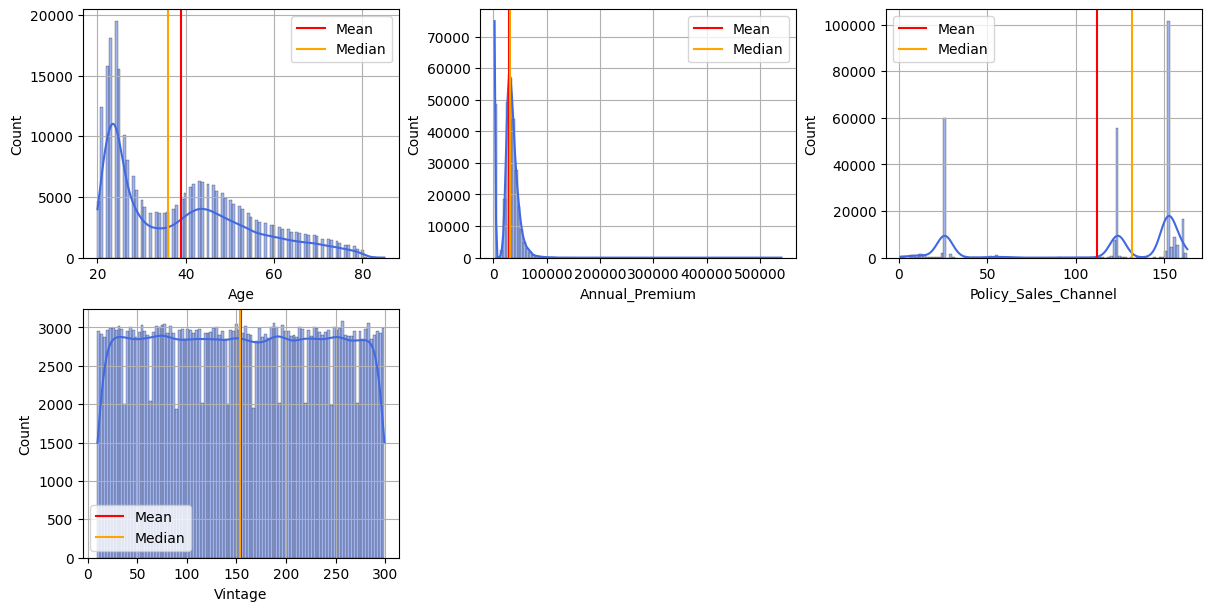

In [48]:
bins = 100
kde = True

columns_num = num_attributes.difference(['Response'])

# Graph Size
# Matrix of 3 columns and n rows
count_num = df_3[columns_num].shape[1]
plot_cols_num = 3
plot_rows_num = math.ceil(count_num / plot_cols_num)

fig_num, axes_num = plt.subplots(
    nrows=plot_rows_num,
    ncols=plot_cols_num,
    figsize=(4 * plot_cols_num, 3 * plot_rows_num),
    constrained_layout=True
)

# Transform the axes into a 1D-Array to make them easier to manipulate.
axes_num = axes_num.flatten()

for i, col in enumerate(columns_num):   
    # Distribution Chart
    sns.histplot(data=df_3.dropna(),
                 x=col,
                 bins=bins, kde=kde,
                 ax=axes_num[i],
                 color='royalblue',
                 edgecolor='black')

    # Mean
    mean = df_3[col].mean()
    axes_num[i].axvline(x=mean, color='red', label='Mean')
    
    # Median
    median = df_3[col].median()
    axes_num[i].axvline(x=median, color='orange', label='Median')
    
    axes_num[i].grid(True)
    axes_num[i].legend()

# Remove blank axes
for j in range(i + 1, len(axes_num)):
    fig_num.delaxes(axes_num[j])
plt.show()

##### Age

<Axes: ylabel='Age'>

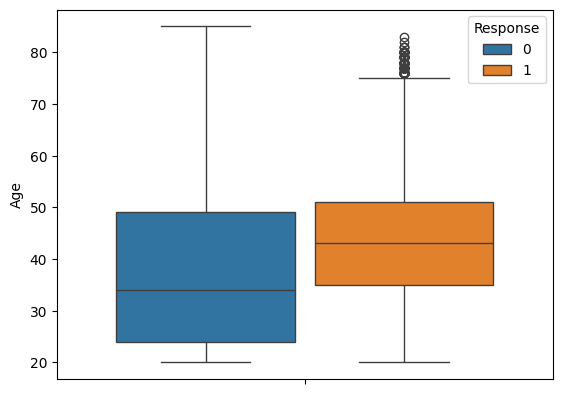

In [49]:
sns.boxplot(data=df_3,hue='Response',y='Age',gap=0.1)

##### Annual_Premium

<Axes: ylabel='Annual_Premium'>

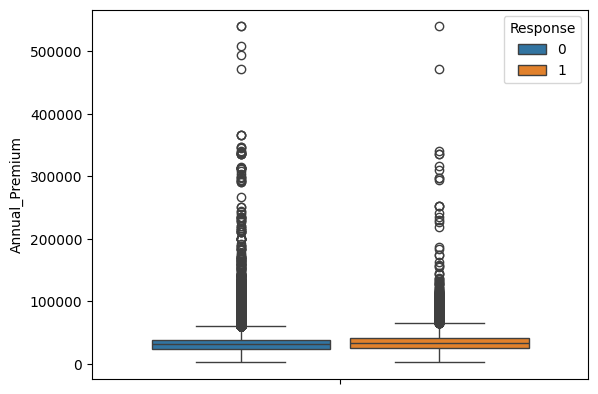

In [50]:
sns.boxplot(data=df_3,hue='Response',y='Annual_Premium',gap=0.1)

##### Policy_Sales_Channel

<Axes: ylabel='Policy_Sales_Channel'>

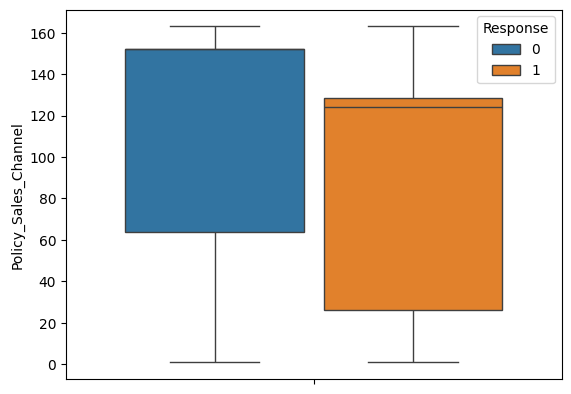

In [51]:
sns.boxplot(data=df_3,hue='Response',y='Policy_Sales_Channel',gap=0.1)

##### Vintage

<Axes: ylabel='Vintage'>

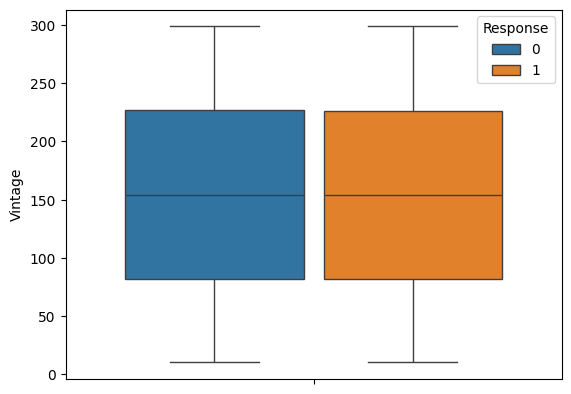

In [52]:
sns.boxplot(data=df_3,hue='Response',y='Vintage',gap=0.1)

### 5.2 Bivariate Analysis

##### Numerical Attributes

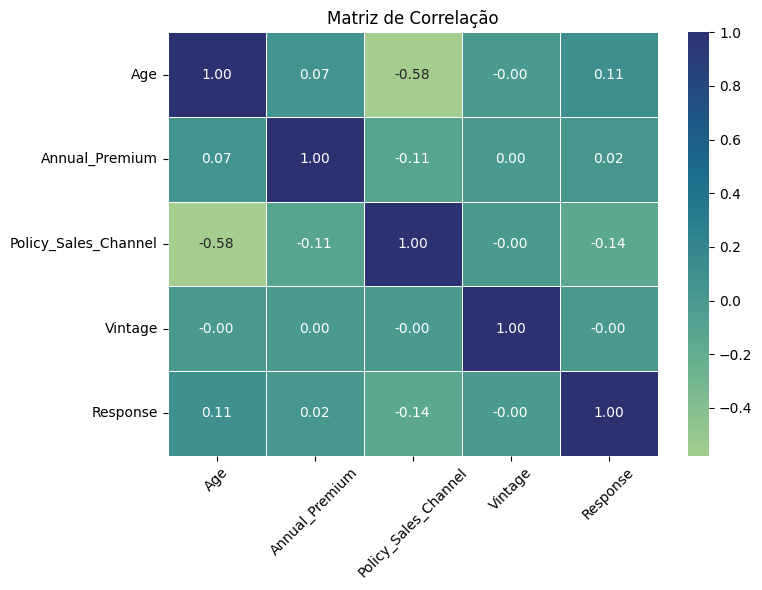

In [53]:
corr_matrix = df_3[num_attributes].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='crest', linewidths=0.5)
plt.xticks(rotation=45)
plt.title("Matriz de Correlação")
plt.tight_layout()
plt.show()

##### Categorical Attributes


🔸 Tabela de contingência: Driving_License x Gender
Gender             Female      Male
Driving_License                    
0                0.245847  0.754153
1                0.458575  0.541425
All              0.458127  0.541873


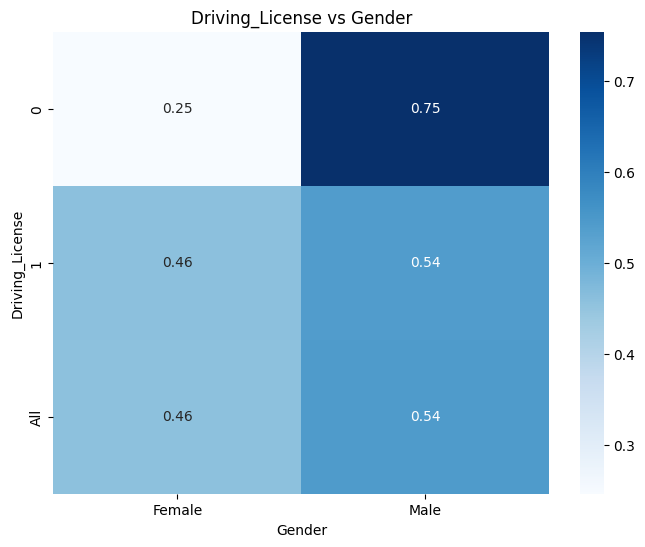


🔸 Tabela de contingência: Driving_License x Previously_Insured
Previously_Insured         0         1
Driving_License                       
0                   0.682724  0.317276
1                   0.541863  0.458137
All                 0.542160  0.457840


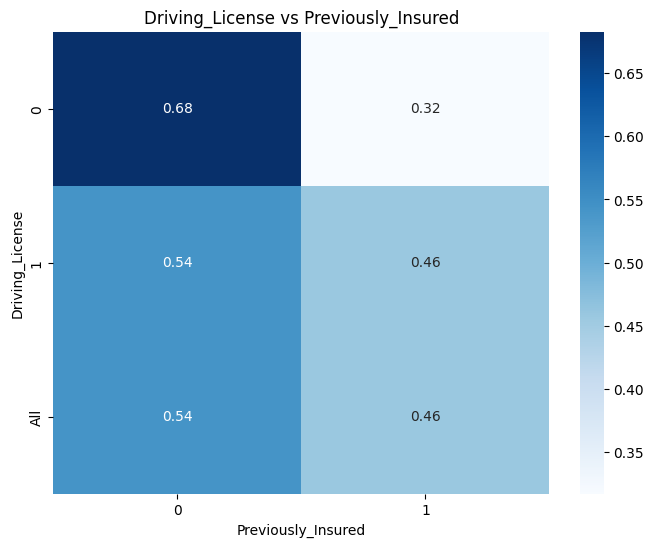


🔸 Tabela de contingência: Driving_License x Region_Code
Region_Code          11.0      15.0      28.0      29.0       3.0      30.0  \
Driving_License                                                               
0                0.009967  0.029900  0.446844  0.031561  0.014950  0.004983   
1                0.024258  0.034884  0.279526  0.029170  0.024352  0.032160   
All              0.024228  0.034874  0.279879  0.029175  0.024333  0.032103   

Region_Code          41.0      46.0      50.0       8.0     Other  
Driving_License                                                    
0                0.038206  0.033223  0.014950  0.088040  0.287375  
1                0.047677  0.051958  0.027020  0.088883  0.360111  
All              0.047658  0.051919  0.026995  0.088881  0.359957  


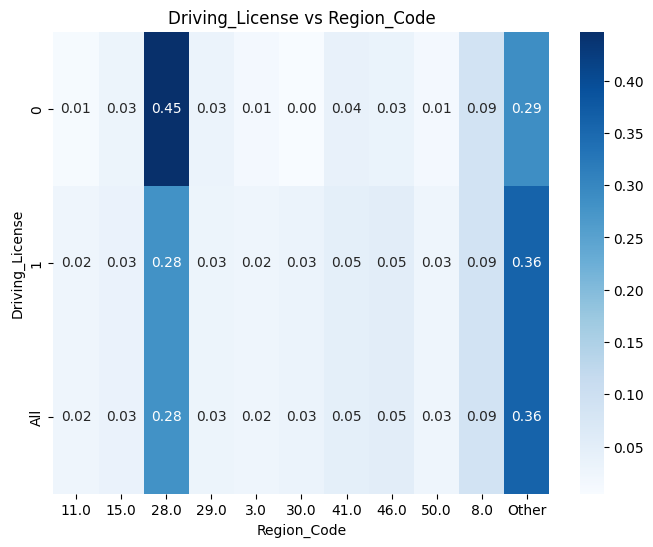


🔸 Tabela de contingência: Driving_License x Vehicle_Age
Vehicle_Age      1-2 Year  < 1 Year  > 2 Years
Driving_License                               
0                0.930233  0.001661   0.068106
1                0.524494  0.433606   0.041900
All              0.525349  0.432696   0.041955


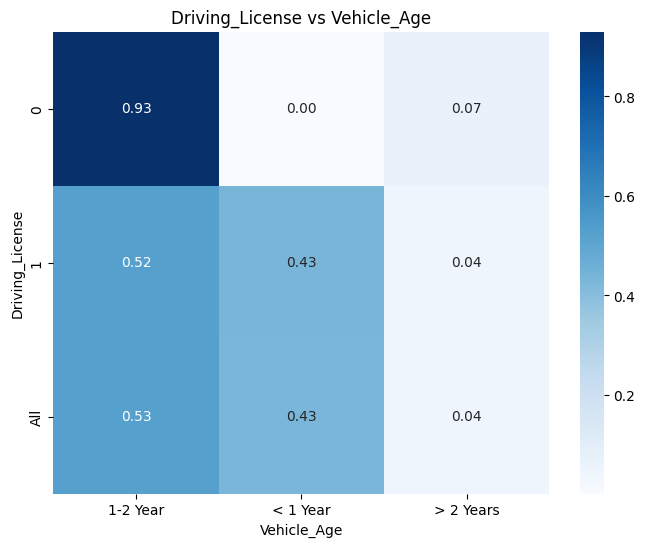


🔸 Tabela de contingência: Driving_License x Vehicle_Damage
Vehicle_Damage         No       Yes
Driving_License                    
0                0.327243  0.672757
1                0.495055  0.504945
All              0.494701  0.505299


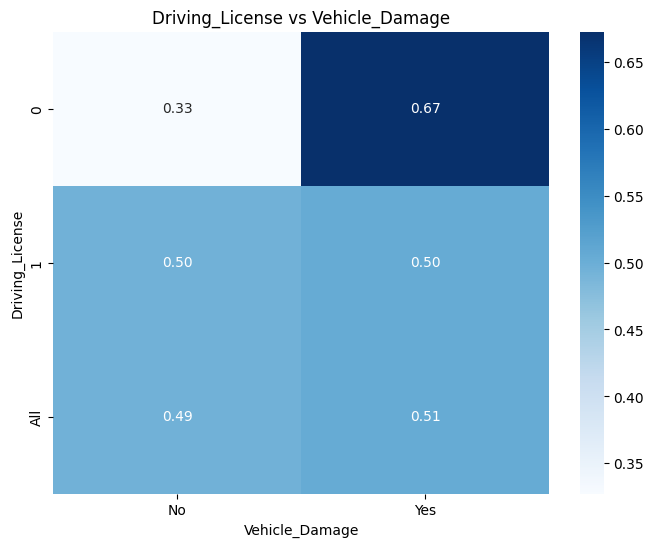


🔸 Tabela de contingência: Gender x Previously_Insured
Previously_Insured         0         1
Gender                                
Female              0.498018  0.501982
Male                0.579479  0.420521
All                 0.542160  0.457840


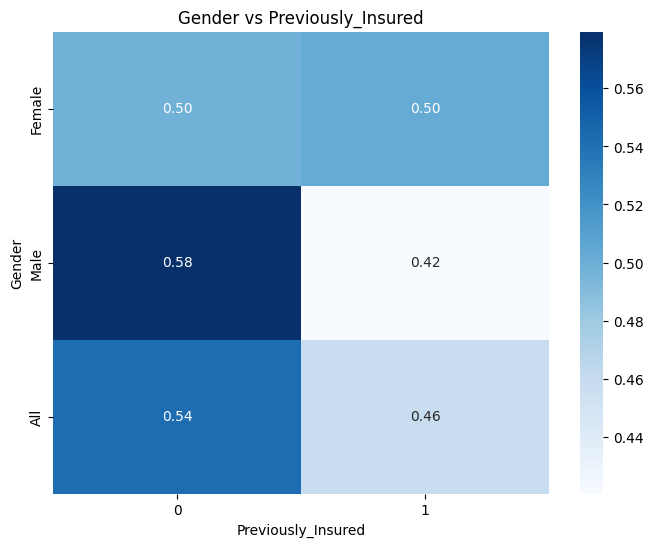


🔸 Tabela de contingência: Gender x Region_Code
Region_Code      11.0      15.0      28.0      29.0       3.0      30.0  \
Gender                                                                    
Female       0.025927  0.038145  0.264955  0.029363  0.023345  0.034945   
Male         0.022791  0.032108  0.292496  0.029015  0.025167  0.029700   
All          0.024228  0.034874  0.279879  0.029175  0.024333  0.032103   

Region_Code      41.0      46.0      50.0       8.0     Other  
Gender                                                         
Female       0.048447  0.052082  0.027683  0.083881  0.371227  
Male         0.046990  0.051781  0.026413  0.093108  0.350430  
All          0.047658  0.051919  0.026995  0.088881  0.359957  


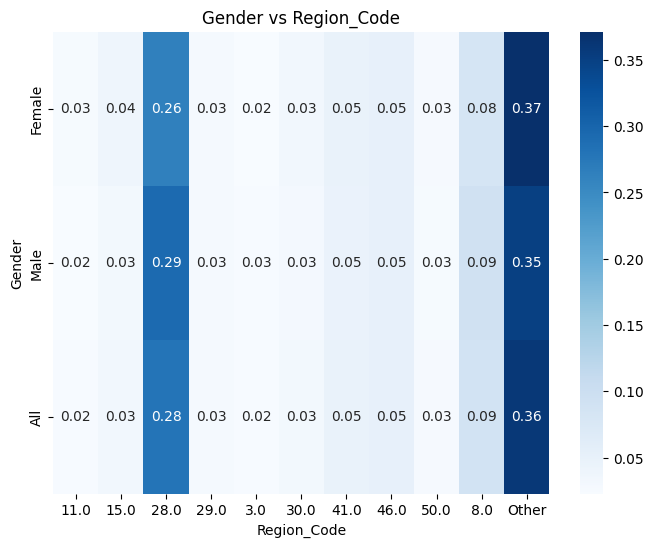


🔸 Tabela de contingência: Gender x Vehicle_Age
Vehicle_Age  1-2 Year  < 1 Year  > 2 Years
Gender                                    
Female       0.445279  0.522028   0.032693
Male         0.593044  0.357171   0.049786
All          0.525349  0.432696   0.041955


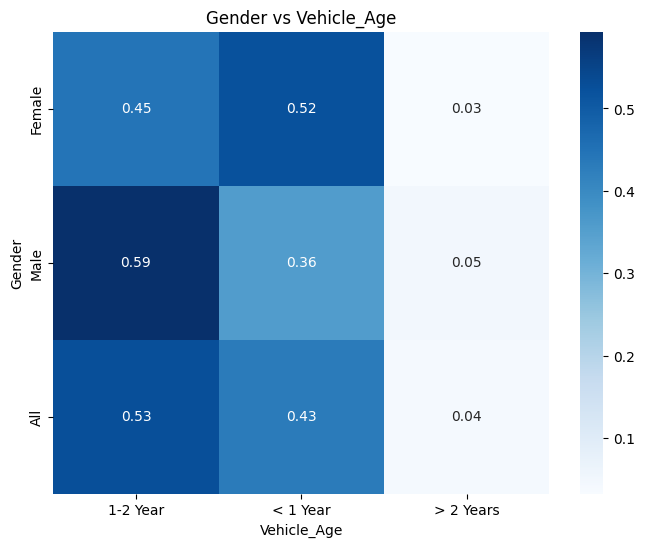


🔸 Tabela de contingência: Gender x Vehicle_Damage
Vehicle_Damage        No       Yes
Gender                            
Female          0.544006  0.455994
Male            0.453016  0.546984
All             0.494701  0.505299


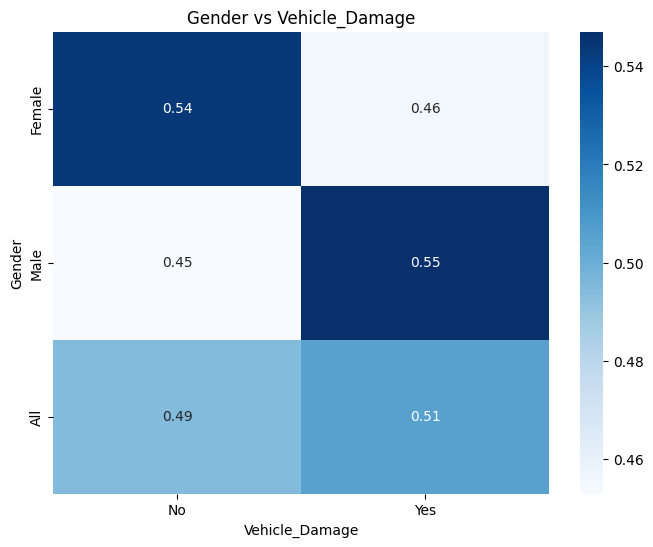


🔸 Tabela de contingência: Previously_Insured x Region_Code
Region_Code             11.0      15.0      28.0      29.0       3.0  \
Previously_Insured                                                     
0                   0.016920  0.034124  0.355381  0.021663  0.023237   
1                   0.032881  0.035762  0.190471  0.038070  0.025629   
All                 0.024228  0.034874  0.279879  0.029175  0.024333   

Region_Code             30.0      41.0      46.0      50.0       8.0     Other  
Previously_Insured                                                              
0                   0.019527  0.038434  0.045571  0.022540  0.080863  0.341739  
1                   0.046995  0.058579  0.059435  0.032270  0.098376  0.381531  
All                 0.032103  0.047658  0.051919  0.026995  0.088881  0.359957  


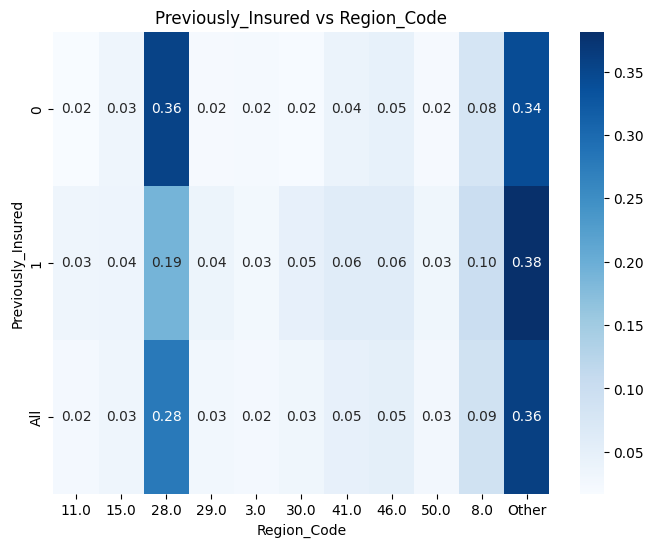


🔸 Tabela de contingência: Previously_Insured x Vehicle_Age
Vehicle_Age         1-2 Year  < 1 Year  > 2 Years
Previously_Insured                               
0                   0.652892  0.269950   0.077159
1                   0.374317  0.625416   0.000267
All                 0.525349  0.432696   0.041955


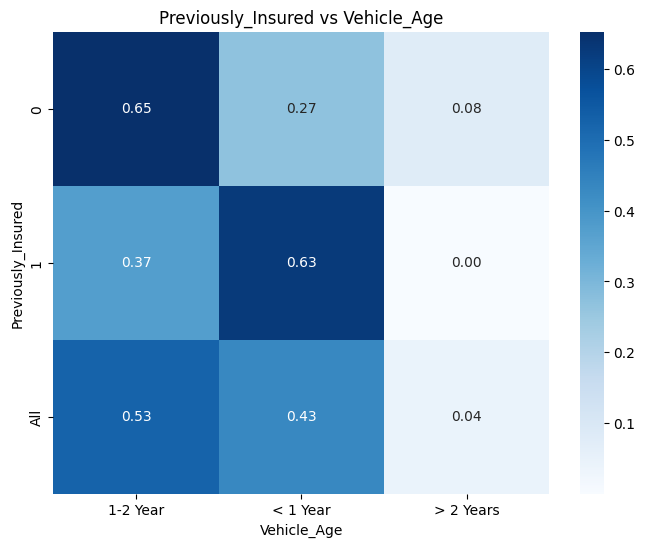


🔸 Tabela de contingência: Previously_Insured x Vehicle_Damage
Vehicle_Damage            No       Yes
Previously_Insured                    
0                   0.116058  0.883942
1                   0.943079  0.056921
All                 0.494701  0.505299


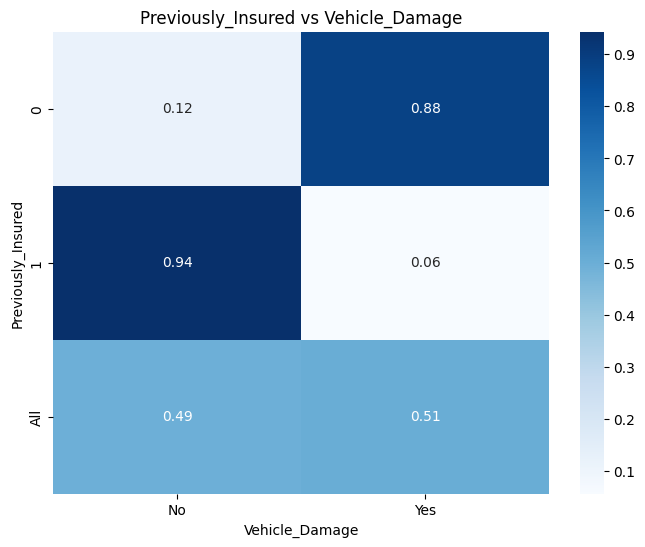


🔸 Tabela de contingência: Region_Code x Vehicle_Age
Vehicle_Age  1-2 Year  < 1 Year  > 2 Years
Region_Code                               
11.0         0.392058  0.591336   0.016606
15.0         0.331360  0.654595   0.014045
28.0         0.737693  0.173092   0.089215
29.0         0.463845  0.517448   0.018707
3.0          0.505104  0.473472   0.021423
30.0         0.315497  0.675458   0.009045
41.0         0.454779  0.523491   0.021730
46.0         0.488544  0.485580   0.025876
50.0         0.470969  0.502592   0.026439
8.0          0.517693  0.450738   0.031569
Other        0.433699  0.541750   0.024551
All          0.525349  0.432696   0.041955


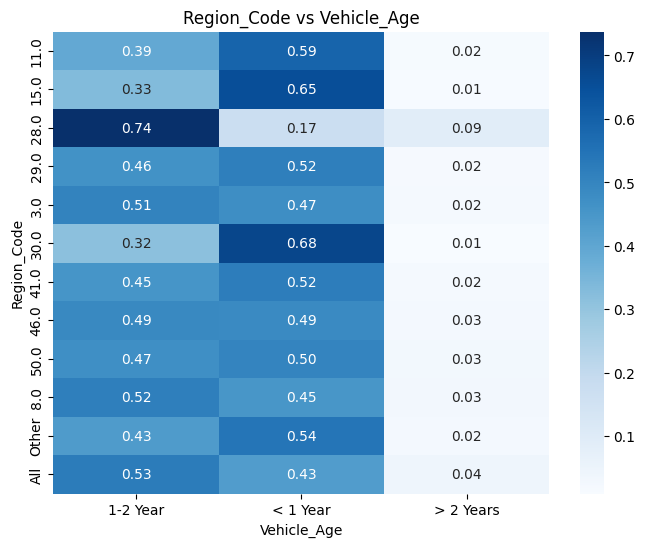


🔸 Tabela de contingência: Region_Code x Vehicle_Damage
Vehicle_Damage        No       Yes
Region_Code                       
11.0            0.646354  0.353646
15.0            0.559591  0.440409
28.0            0.339383  0.660617
29.0            0.623816  0.376184
3.0             0.519051  0.480949
30.0            0.683522  0.316478
41.0            0.582807  0.417193
46.0            0.552830  0.447170
50.0            0.587481  0.412519
8.0             0.543515  0.456485
Other           0.530961  0.469039
All             0.494701  0.505299


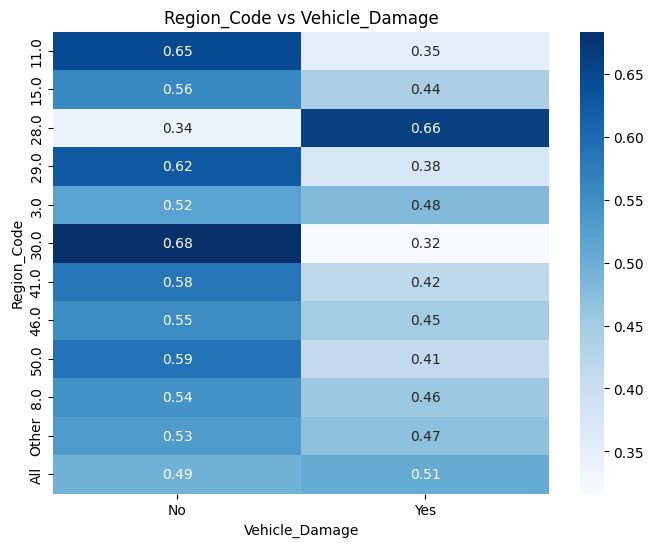


🔸 Tabela de contingência: Vehicle_Age x Vehicle_Damage
Vehicle_Damage        No       Yes
Vehicle_Age                       
1-2 Year        0.359614  0.640386
< 1 Year        0.706585  0.293415
> 2 Years       0.001001  0.998999
All             0.494701  0.505299


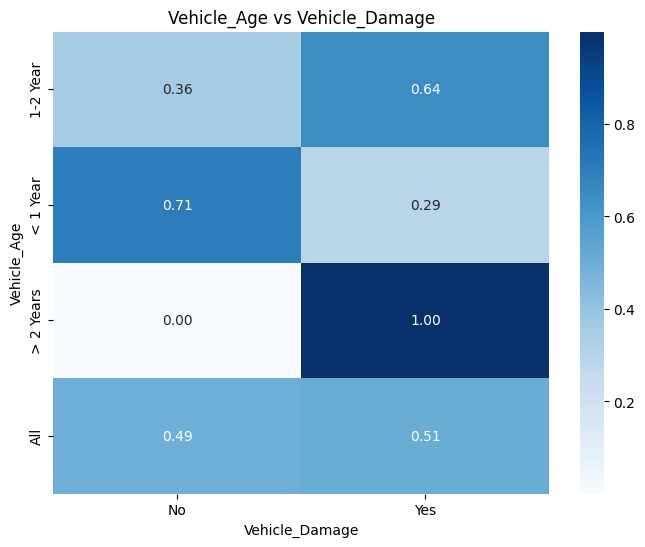

In [54]:
df_3 = df_2.copy()

normalize = 'index'
top_regions = df_3['Region_Code'].value_counts().index[:10]

for col1, col2 in combinations(cat_attributes, 2):    
    
    print(f"\n🔸 Tabela de contingência: {col1} x {col2}")

    index = df_3[col1].apply(lambda x: x if x in top_regions else 'Other') if col1 == 'Region_Code' else df_3[col1]
    columns = df_3[col2].apply(lambda x: x if x in top_regions else 'Other') if col2 == 'Region_Code' else df_3[col2]
    
    tabela = pd.crosstab(index, columns, normalize=normalize, margins=True)     
    
    print(tabela)

    plt.figure(figsize=(8, 6))
    sns.heatmap(tabela, annot=True, fmt=".2f", cmap="Blues")
    plt.title(f'{col1} vs {col2}')
    plt.show()

In [55]:
df_2['Region_Code'].unique()

array(['7.0', '26.0', '11.0', '8.0', '28.0', '3.0', '19.0', '35.0',
       '41.0', '36.0', '10.0', '24.0', '30.0', '48.0', '12.0', '49.0',
       '33.0', '13.0', '21.0', '46.0', '9.0', '29.0', '45.0', '15.0',
       '38.0', '37.0', '14.0', '47.0', '39.0', '2.0', '25.0', '50.0',
       '43.0', '1.0', '32.0', '34.0', '31.0', '18.0', '22.0', '6.0',
       '5.0', '0.0', '23.0', '44.0', '42.0', '20.0', '17.0', '27.0',
       '40.0', '16.0', '4.0', '52.0', '51.0'], dtype=object)

In [56]:
top_regions

Index(['28.0', '8.0', '46.0', '41.0', '15.0', '30.0', '29.0', '50.0', '3.0',
       '11.0'],
      dtype='object', name='Region_Code')

In [57]:
'28.0' in list(top_regions)

True

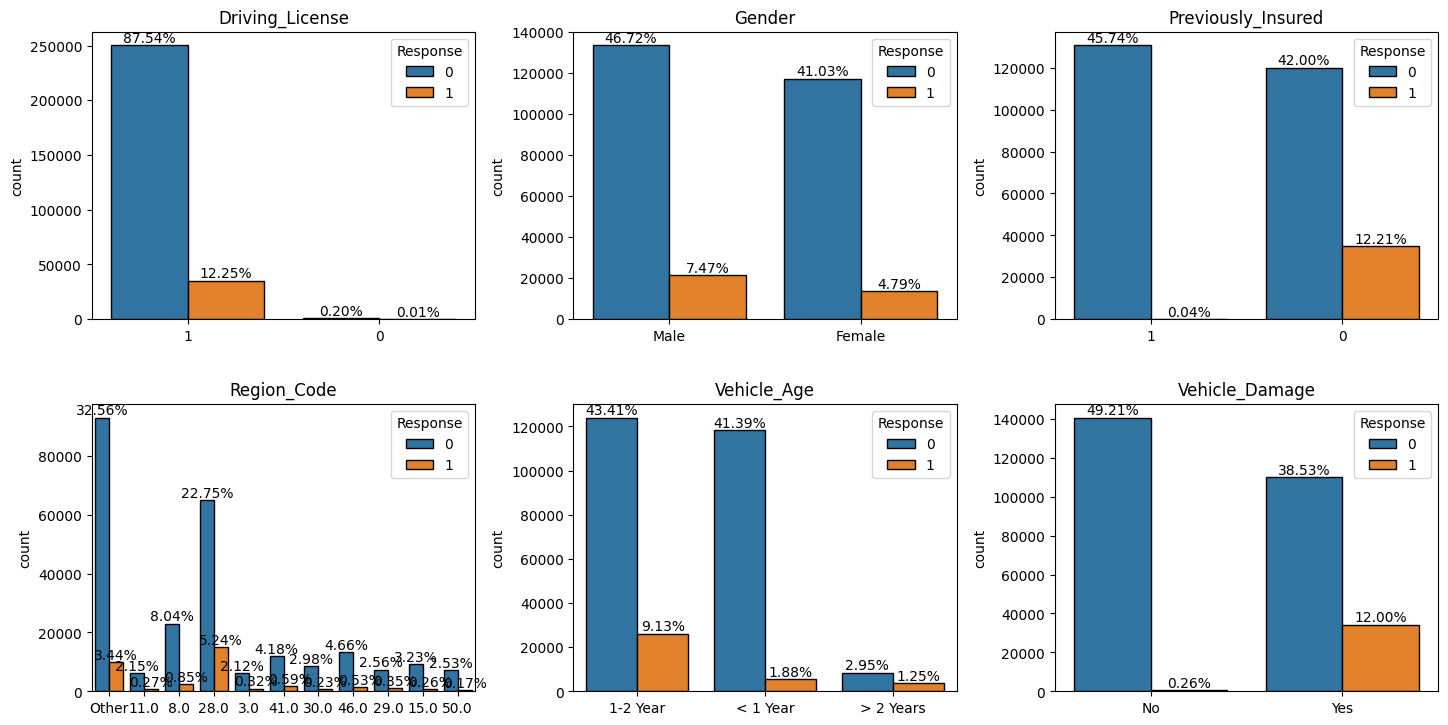

In [58]:
df_3 = df_2.copy()
df_3['Region_Code'] = df_3['Region_Code'].apply(lambda x: x if x in top_regions else 'Other')

# Graph Size
# Matrix of 3 columns and n rows
count_cat = df_3[cat_attributes].shape[1]
plot_cols_cat = 3
plot_rows_cat = math.ceil(count_cat / plot_cols_cat)

fig_cat, axes_cat = plt.subplots(
    nrows=plot_rows_cat,
    ncols=plot_cols_cat,
    figsize=(5 * plot_cols_cat, 4 * plot_rows_cat)
)
fig_cat.tight_layout(pad=4.0)

# Transform the axes into a 1D-Array to make them easier to manipulate.
axes_cat = axes_cat.flatten()

for i, col in enumerate(cat_attributes):
    # Sort the columns
    order = list(df_3[col].infer_objects().fillna('nulos').unique())
    
    if 'nulos' in order:
        order.remove('nulos')
        order.append('nulos')

        
    palette = ['royalblue'] * (len(order) - 1) + ['red']
 
    ax = sns.countplot(data=df_3.infer_objects().fillna('nulos'),
                       ax=axes_cat[i],
                       x=col,
                       hue='Response',
                       edgecolor='black',
                       order=order)
    
    # Extract the frequency of each categorical attribute
    for container in ax.containers:            
        labels = [f'{(v.get_height()/len(df_3))*100:.2f}%' for v in container]
        ax.bar_label(container, labels=labels)    
 
    axes_cat[i].set_title(col)
    axes_cat[i].set_xlabel(None)
   


# Remove blank axes
for j in range(i + 1, len(axes_cat)):
    fig_cat.delaxes(axes_cat[j])

plt.show()

<br>

<br>

# 6. Data Processing

In [59]:
df_4 = df_2.copy()

In [60]:
X_train = df_4.drop('Response',axis=1)
y_train = df_4['Response']

In [61]:
X_train.shape

(285831, 10)

In [62]:
X_train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
153178,Male,76,1,7.0,1,1-2 Year,No,2630.0,11.0,103
50533,Female,21,1,26.0,1,< 1 Year,No,24404.0,152.0,218
247389,Female,37,1,11.0,0,1-2 Year,Yes,35475.0,152.0,59
274859,Male,31,1,8.0,1,1-2 Year,No,35135.0,154.0,170
219318,Male,57,1,28.0,0,1-2 Year,Yes,45055.0,26.0,221


In [63]:
X_train

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
153178,Male,76,1,7.0,1,1-2 Year,No,2630.0,11.0,103
50533,Female,21,1,26.0,1,< 1 Year,No,24404.0,152.0,218
247389,Female,37,1,11.0,0,1-2 Year,Yes,35475.0,152.0,59
274859,Male,31,1,8.0,1,1-2 Year,No,35135.0,154.0,170
219318,Male,57,1,28.0,0,1-2 Year,Yes,45055.0,26.0,221
...,...,...,...,...,...,...,...,...,...,...
45919,Female,21,1,5.0,0,< 1 Year,Yes,27783.0,160.0,218
93597,Male,25,1,8.0,1,< 1 Year,No,52768.0,152.0,284
51304,Male,41,1,28.0,1,1-2 Year,No,42115.0,122.0,238
230904,Male,42,1,50.0,0,1-2 Year,Yes,34100.0,124.0,145


In [67]:
num_attributes

Index(['Age', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response'], dtype='object')

In [65]:
out_peak_columns = ['Annual_Premium']
one_hot_cols = ['Gender','Vehicle_Age','Vehicle_Damage']
target_encoder_cols = ['Region_Code']
min_max_cols = ['Age','Vintage']
kmeans_cols = ['Policy_Sales_Channel']

k = 3

numeric_transformer = Pipeline([
    ('scaler', MinMaxScaler())
])
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False,drop='first'))
])
target_encoder_transformer = Pipeline([
    ('targetEncoder',ce.TargetEncoder(smoothing = 0.3))
])
annual_premium_outlier_peak_transformer = Pipeline([
    ('outliers',IQROutlierRemover()),
    ('peak',PeakValueTransformer(peak_value = 2630 , method='median')),
    ('scaler', MinMaxScaler())
])
cluster_transformer = Pipeline([
    ('kbins', KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')),  # retorna 0,1,2
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))  # one-hot e dropa a primeira coluna
])


preprocessor = ColumnTransformer([
    ('out_peak',annual_premium_outlier_peak_transformer,out_peak_columns),
    ('num', numeric_transformer, min_max_cols),
    ('cat', categorical_transformer, one_hot_cols),
    ('target',target_encoder_transformer,target_encoder_cols),
    ('kmeans',cluster_transformer,kmeans_cols)
], remainder='passthrough')

pipeline = ImbPipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100)))
])



In [66]:
with open('pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

#### TESTE

In [ ]:
X_teste = df_4.drop(columns=['Response'])
y_teste = df_4['Response']

In [ ]:
pipeline.fit(X_teste,y_teste)

In [ ]:
X_transformed = preprocessor.transform(X_test)


In [ ]:
for name, transformer, cols in preprocessor.transformers_:
    Xt = transformer.transform(X_test[cols])
    print(f"{name}: input cols={cols} -> output shape={Xt.shape}")


In [ ]:
from sklearn.compose import ColumnTransformer

def get_column_names(ct: ColumnTransformer):
    feature_names = []

    for name, transformer, cols in ct.transformers_:
        if transformer == 'passthrough':
            feature_names.extend(cols)
        else:
            if isinstance(transformer, Pipeline):
                last_step = transformer.steps[-1][1]
            else:
                last_step = transformer

            # para transformers que não têm get_feature_names_out (como PeakValueTransformer)
            if hasattr(last_step, 'get_feature_names_out'):
                try:
                    names = last_step.get_feature_names_out()
                except TypeError:
                    names = last_step.get_feature_names_out(cols)
                feature_names.extend(names)
            else:
                # fallback: adiciona _flag para PeakValueTransformer
                for c in cols:
                    feature_names.append(c)
                    if isinstance(last_step, PeakValueTransformer):
                        feature_names.append(f"{c}_flag")
    return feature_names


In [ ]:
X_transformed = preprocessor.transform(X_test)
feature_names = get_column_names(preprocessor)
X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names, index=X_test.index)

X_transformed_df


In [ ]:
# Acessando transformação indepdenentes
# out_peak: input cols=['Annual_Premium'] -> output shape=(95278, 2)
# num: input cols=['Age', 'Vintage'] -> output shape=(95278, 2)
# cat: input cols=['Gender', 'Vehicle_Age', 'Vehicle_Damage'] -> output shape=(95278, 4)
# target: input cols=['Region_Code'] -> output shape=(95278, 1)
# kmeans: input cols=['Policy_Sales_Channel'] -> output shape=(95278, 2)
# remainder: input cols=['Driving_License', 'Previously_Insured'] -> output shape=(95278, 2)

# pegar o transformer out_peak
out_peak_transformer = preprocessor.named_transformers_['out_peak']

# transformar só a coluna Annual_Premium
X_out_peak = out_peak_transformer.transform(X_test[['Annual_Premium']])


In [ ]:
X_out_peak

In [ ]:
num_transformer = preprocessor.named_transformers_['num']
X_num = num_transformer.transform(X_test[['Age', 'Vintage']])

cat_transformer = preprocessor.named_transformers_['cat']
X_cat = cat_transformer.transform(X_test[['Gender','Vehicle_Age','Vehicle_Damage']])


In [ ]:
kmeans_transformer = preprocessor.named_transformers_['kmeans']
X_kmeans = kmeans_transformer.transform(X_test[['Policy_Sales_Channel']])

In [ ]:
df_3['Annual_Premium'].min()

In [ ]:
df_3[df_3['Annual_Premium']==2630]

<br>

<br>

# 7. Cross-Validation

Decision Tree  
Random Forest   
Logistict Regression  
Gradient Boosting Classifier   
SVM   
KNN


In [68]:
with open('pipeline.pkl', 'rb') as f:
    pipeline_processor = pickle.load(f)

In [69]:
models = {
    'Decision Tree':DecisionTreeClassifier(random_state =42),
    'Random Forest':RandomForestClassifier(random_state =42),
    'Logistic Regression':LogisticRegression(random_state =42),
    'Gradient Boosting':GradientBoostingClassifier(random_state =42),
    'KNN':KNeighborsClassifier()
}

pipelines = {}
for name,model in models.items():
    pipelines[name] = ImbPipeline([
        ('preprocess', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100))),
        ('classifier', model)
    ])

In [38]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

metrics_auc = {}
for name, pipe in pipelines.items():
    scores_auc = cross_val_score(pipe, X_train, y_train, cv=skf, scoring='roc_auc')

    auc = f'{scores_auc.mean():.3f} ± {scores_auc.std():.3f}'

    print(f'Modelo {name} - AUC médio: {scores_auc.mean():.3f} - Std: {scores_auc.std():.3f}')
    print('\n')
    
    
    
    scores = [
        auc
    ]
    metrics_auc[name] = scores
    
val_auc = pd.DataFrame(metrics_auc,index=['AUC']).T

Modelo Decision Tree - AUC médio: 0.601 - Std: 0.000


Modelo Random Forest - AUC médio: 0.818 - Std: 0.002


Modelo Logistic Regression - AUC médio: 0.815 - Std: 0.002


Modelo Gradient Boosting - AUC médio: 0.839 - Std: 0.002


Modelo KNN - AUC médio: 0.784 - Std: 0.003




In [54]:
val_auc

,AUC
Decision Tree,0.602 ± 0.002
Random Forest,0.817 ± 0.001
Logistic Regression,0.815 ± 0.001
Gradient Boosting,0.838 ± 0.001
KNN,0.784 ± 0.001


In [70]:
# NOVO
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


metrics = {}
for name, pipe in pipelines.items():
    scores_recall = cross_val_score(pipe, X_train, y_train, cv=skf, scoring='recall')
    scores_precision = cross_val_score(pipe, X_train, y_train, cv=skf, scoring='precision')
    scores_f1 = cross_val_score(pipe, X_train, y_train, cv=skf, scoring='f1')

    recall = f'{scores_recall.mean():.3f} ± {scores_recall.std():.3f}'
    precision = f'{scores_precision.mean():.3f} ± {scores_precision.std():.3f}'
    f1 = f'{scores_f1.mean():.3f} ± {scores_f1.std():.3f}'

    print(f'Modelo {name} - Recall médio: {scores_recall.mean():.3f} - Std: {scores_recall.std():.3f}')
    print(f'Modelo {name} - Precision médio: {scores_precision.mean():.3f} - Std: {scores_precision.std():.3f}')
    print(f'Modelo {name} - F1 médio: {scores_f1.mean():.3f} - Std: {scores_f1.std():.3f}')
    print('\n')
    
    
    
    scores = [
        recall,
        precision,
        f1
    ]
    metrics[name] = scores

val = pd.DataFrame(metrics,index=['Recall','Precision','F1']).T
    

Modelo Decision Tree - Recall médio: 0.313 - Std: 0.009
Modelo Decision Tree - Precision médio: 0.276 - Std: 0.003
Modelo Decision Tree - F1 médio: 0.293 - Std: 0.005


Modelo Random Forest - Recall médio: 0.327 - Std: 0.005
Modelo Random Forest - Precision médio: 0.309 - Std: 0.004
Modelo Random Forest - F1 médio: 0.318 - Std: 0.003


Modelo Logistic Regression - Recall médio: 0.977 - Std: 0.001
Modelo Logistic Regression - Precision médio: 0.250 - Std: 0.001
Modelo Logistic Regression - F1 médio: 0.398 - Std: 0.001


Modelo Gradient Boosting - Recall médio: 0.854 - Std: 0.009
Modelo Gradient Boosting - Precision médio: 0.290 - Std: 0.002
Modelo Gradient Boosting - F1 médio: 0.433 - Std: 0.002


Modelo KNN - Recall médio: 0.678 - Std: 0.005
Modelo KNN - Precision médio: 0.272 - Std: 0.003
Modelo KNN - F1 médio: 0.388 - Std: 0.003




In [71]:
val

,Recall,Precision,F1
Decision Tree,0.313 ± 0.009,0.276 ± 0.003,0.293 ± 0.005
Random Forest,0.327 ± 0.005,0.309 ± 0.004,0.318 ± 0.003
Logistic Regression,0.977 ± 0.001,0.250 ± 0.001,0.398 ± 0.001
Gradient Boosting,0.854 ± 0.009,0.290 ± 0.002,0.433 ± 0.002
KNN,0.678 ± 0.005,0.272 ± 0.003,0.388 ± 0.003


In [72]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

def precision_recall_at_k(y_true, y_scores, k=0.1):
    """Calcula precision e recall nos top k% com maiores scores"""
    n = int(len(y_scores) * k)
    idx = np.argsort(y_scores)[::-1][:n]  # índices dos top k%

    y_pred_at_k = np.zeros_like(y_true)
    y_pred_at_k[idx] = 1  # marca como positivo só os top k%

    precision = precision_score(y_true, y_pred_at_k)
    recall = recall_score(y_true, y_pred_at_k)
    return precision, recall


In [73]:
X_train.dtypes

Gender                   object
Age                       int64
Driving_License          object
Region_Code              object
Previously_Insured       object
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
dtype: object

In [75]:
# X_train = X_train.reset_index(drop=True)
# y_train = y_train.reset_index(drop=True)

k_percent = 0.10  # top 10%
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

metrics_at_k = {}

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)


for name, pipe in pipelines.items():
    
    precisions = []
    recalls = []
    
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_skf, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_skf, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Treine seu pipeline com SMOTE e o modelo clf
        pipeline = pipelines[name]
        pipeline.fit(X_train_skf, y_train_skf)
        
        # Pegue as probabilidades da classe 1
        y_proba = pipeline.predict_proba(X_val)[:, 1]
        
        # Calcule precision@k e recall@k
        p_k, r_k = precision_recall_at_k(y_val, y_proba, k=k_percent)
        precisions.append(p_k)
        recalls.append(r_k)

    recall_at_k = np.array(recalls)
    precision_at_k = np.array(precisions)

    recall = f'{recall_at_k.mean():.3f} ± {recall_at_k.std():.3f}'
    precision = f'{precision_at_k.mean():.3f} ± {precision_at_k.std():.3f}'

    metrics_at_k[name] = [recall,precision]

val_at_k = pd.DataFrame(metrics_at_k,index=[f'Recall_at_{k_percent*100:.0f}%',f'Precision_at_{k_percent*100:.0f}%']).T
    

In [76]:
val_at_k

,Recall_at_10%,Precision_at_10%
Decision Tree,0.226 ± 0.004,0.277 ± 0.005
Random Forest,0.257 ± 0.005,0.315 ± 0.006
Logistic Regression,0.237 ± 0.003,0.290 ± 0.004
Gradient Boosting,0.284 ± 0.007,0.349 ± 0.008
KNN,0.237 ± 0.004,0.290 ± 0.005


# 8. Grid-Search

In [77]:
param_grid_gb = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.05],
    'classifier__max_depth': [1,2,3,4],
}


In [78]:

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_gb = GridSearchCV(
    estimator=pipelines['Gradient Boosting'],
    param_grid=param_grid_gb,
    scoring='roc_auc',
    cv=skf,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_gb.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__learning_rate': [0.01, 0.05], 'classifier__max_depth': [1, 2, ...], 'classifier__n_estimators': [100, 200]}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,transformers,"[('out_peak', ...), ('num', ...), ...]"


In [79]:
params = {
    x.split('__')[1]:v for x,v in grid_gb.best_params_.items()
}

In [80]:
params

{'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 200}

<br>

# 9.Model

In [81]:
with open('pipeline.pkl', 'rb') as f:
    pipeline_processor = pickle.load(f)

In [82]:
params = {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 200}

In [83]:
pipeline_model = pipeline_processor.steps + [('model', GradientBoostingClassifier(**params, random_state=42))]

# Crie uma nova pipeline com esses steps
pipeline = ImbPipeline(pipeline_model)

In [84]:
print([name for name, step in pipeline_processor.steps])


['preprocess', 'smote', 'feature_selection']


In [85]:
pipeline.fit(X_train,y_train)

,steps,"[('preprocess', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('out_peak', ...), ('num', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [86]:
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

recall_train = recall_score(y_train,y_train_pred)
recall_test = recall_score(y_test,y_test_pred)
precision_train = precision_score(y_train,y_train_pred)
precision_test = precision_score(y_test,y_test_pred)

print(f'Train Precision:{precision_train}')
print(f'Test Precision{precision_test}\n')
print(f'Train Recall{recall_train}')
print(f'Test Recall{recall_test}')

Train Precision:0.2815938468112381
Test Precision0.2672821109253471

Train Recall0.9029458780543503
Test Recall0.9445966775132728


In [ ]:
27.128 -> False positive
1.138 -> False negative
56.472 -> True negative
10.540 -> True positive

In [87]:
accuracy_score(y_train,y_train_pred)

0.7057701928762101

In [88]:
accuracy_score(y_test,y_test_pred)

0.6758223304435441

C:\Users\joao\AppData\Local\Temp\ipykernel_11316\192992842.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lift_table = df.groupby("decile").apply(


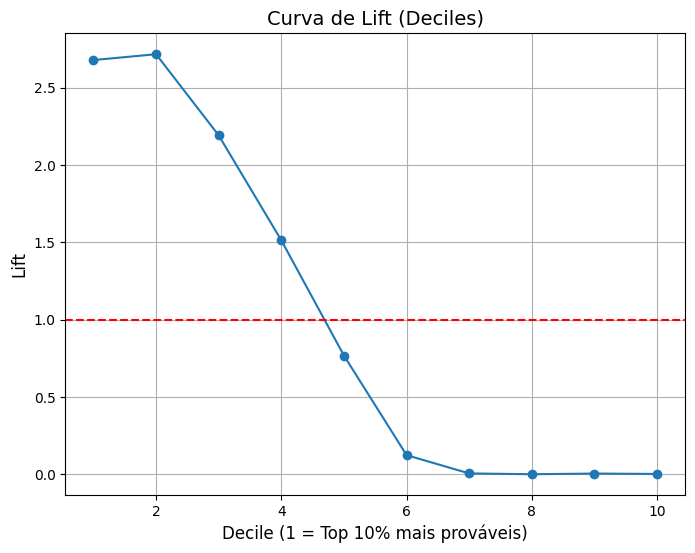

In [89]:
# 4. Obter probabilidades preditas
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# 5. Criar dataframe com labels e probabilidades
df = pd.DataFrame({"y_true": y_test, "y_proba": y_pred_proba})

# Ordenar por probabilidade decrescente
df = df.sort_values("y_proba", ascending=False).reset_index(drop=True)

# 6. Dividir em deciles (10 grupos iguais)
df["decile"] = pd.qcut(df.index, 10, labels=False)

# 7. Calcular Lift
base_rate = df["y_true"].mean()  # taxa média da base
lift_table = df.groupby("decile").apply(
    lambda x: x["y_true"].mean() / base_rate
)

# 8. Plotar curva de Lift
plt.figure(figsize=(8,6))
plt.plot(range(1, 11), lift_table.values, marker='o')
plt.axhline(y=1, color='r', linestyle='--')  # linha do acaso
plt.title("Curva de Lift (Deciles)", fontsize=14)
plt.xlabel("Decile (1 = Top 10% mais prováveis)", fontsize=12)
plt.ylabel("Lift", fontsize=12)
plt.grid(True)
plt.show()